In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from functools import partial

In [2]:
def nc_to_df(nc_set):
    flat_size = np.product([nc_set.dimensions[k].size for k in nc_set.dimensions.keys()])
    return pd.DataFrame({k:np.reshape(nc_set[k],flat_size) for k in nc_set.variables.keys()})

In [3]:
def pole_proj(lat, lon):
    r = 90-lat
    theta = lon*np.pi/180
    return r*np.cos(theta), r*np.sin(theta)

In [4]:
def highpass_arr(arr, cutoff=0, na_val=np.nan):
    return np.array(list(map(lambda x: x if x>=cutoff else na_val, arr)))

Data files taken from NASA's [Operation IceBridge Data Portal](https://nsidc.org/icebridge/portal/map), "CryoSat-2 Level-4 Sea Ice" dataset.

In [5]:
it_df = nc_to_df(nc.Dataset(f'RDEFT4_2017/RDEFT4_20170101.nc'))

In [6]:
it_df.head()

,freeboard,ice_con,lat,lon,roughness,sea_ice_thickness,snow_density,snow_depth
0,-999.0,-9999.0,31.102671,168.320419,-999.0,-9999.0,-9999.0,-9999.0
1,-999.0,-9999.0,31.199409,168.148758,-999.0,-9999.0,-9999.0,-9999.0
2,-999.0,-9999.0,31.295799,167.976395,-999.0,-9999.0,-9999.0,-9999.0
3,-999.0,-9999.0,31.391830,167.803375,-999.0,-9999.0,-9999.0,-9999.0
4,-999.0,-9999.0,31.487499,167.629684,-999.0,-9999.0,-9999.0,-9999.0


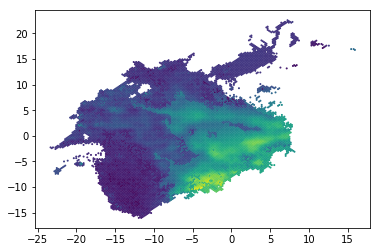

In [7]:
it_z = highpass_arr(it_df['sea_ice_thickness'],-10)
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=1,c=it_z)
plt.show()

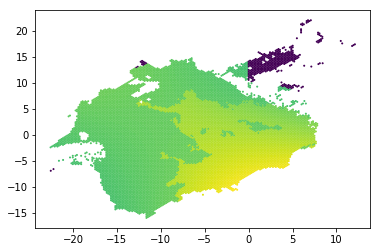

In [8]:
it_z = np.exp(highpass_arr(it_df['snow_depth'],-10))
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=1,c=it_z)
plt.show()

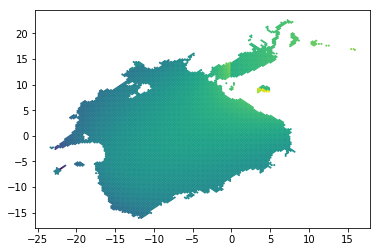

In [9]:
it_z = highpass_arr(it_df['snow_density'],-10)
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=1,c=it_z)
plt.show()

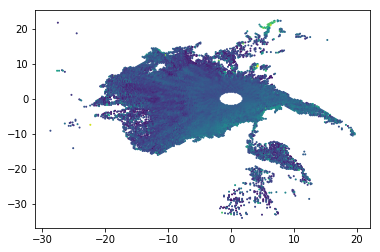

In [10]:
it_z = highpass_arr(it_df['roughness'],-10)
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=1,c=it_z)
plt.show()

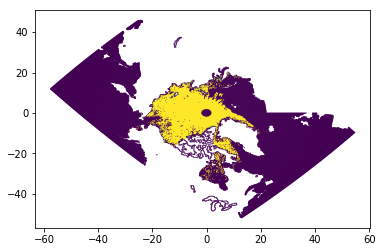

In [11]:
it_z = highpass_arr(it_df['freeboard'],-1000)
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=1,c=it_z,linewidths=0)
plt.show()

Using the NC file's image coordinates directly:

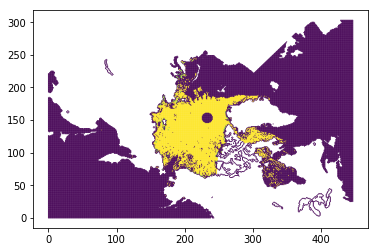

In [12]:
it_z = highpass_arr(it_df['freeboard'],-1000)
plt.scatter(it_df.index//304,it_df.index%304,s=1,c=it_z,linewidths=0)
plt.show()

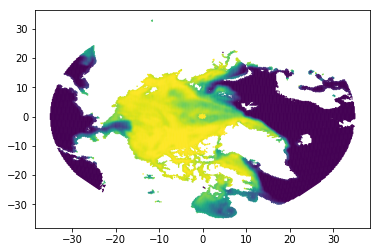

In [13]:
it_z = highpass_arr(it_df['ice_con'],-10)
plt.scatter(*pole_proj(it_df['lat'],it_df['lon']),s=2,c=it_z,linewidths=0)
plt.show()

## Load multiple datasets 
I have selected the first of each month from early 2017

In [14]:
it_dfs = {}
for k in ['01','02','03','04','05']:
    it_dfs[k] = nc_to_df(nc.Dataset(f'RDEFT4_2017/RDEFT4_2017{k}01.nc'))

Difference in ice thickness across one month:

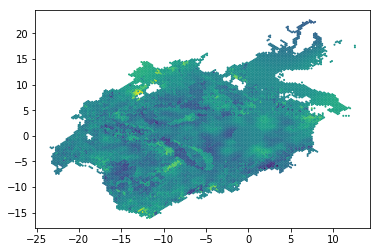

In [15]:
it_z = highpass_arr(it_dfs['04']['sea_ice_thickness']) - highpass_arr(it_dfs['05']['sea_ice_thickness'])
plt.scatter(*pole_proj(it_dfs['01']['lat'],it_dfs['01']['lon']),c=it_z,s=1)
plt.show()

Difference in ice coverage across two months:

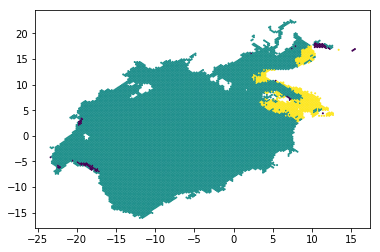

In [16]:
m1=it_dfs['05']['sea_ice_thickness']
m2=it_dfs['03']['sea_ice_thickness']

it_z = m1 - m2.loc[(m1>-10) |(m2>-10)]
plt.scatter(*pole_proj(it_dfs['01']['lat'],it_dfs['01']['lon']),c=it_z,s=1)
plt.show()

## Cross section of ice sheet

Through column 170 of the NC file's 304x448 "pixel" grid:

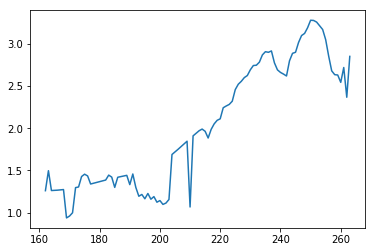

In [17]:
it_slice = it_df.loc[it_df.index%304==170]
plt.plot(it_slice.index//304,highpass_arr(it_slice['sea_ice_thickness']))
plt.show()

Through row 234 of the NC file's 304x448 "pixel" grid:

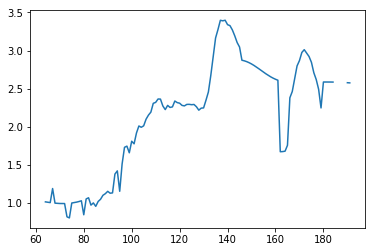

In [18]:
it_slice = it_df.loc[it_df.index//304==234]
plt.plot(it_slice.index%304,highpass_arr(it_slice['sea_ice_thickness']))
plt.show()

## Making the animated line plot

In [19]:
def plot_many_lines(df_array, column, trails=5, slice_index=160, slices_dim=304, xlim=None, ylim=None, low_cut=0, file_prefix='plots/line_plot_', zeroes=None, dpi=100):
    
    slices_bool = df_array[0].index%slices_dim == slice_index
    plt.clf()
    
    if zeroes is None:
        zeroes = len(str(len(df_array)))
    if xlim is None:
        xlim_0=min(min(df.loc[slices_bool & (df[column]>=low_cut)].index//slices_dim) for df in df_array)
        xlim_1=max(max(df.loc[slices_bool & (df[column]>=low_cut)].index//slices_dim) for df in df_array)
        xpad = (xlim_1-xlim_0)*.05
        xlim = [xlim_0-xpad,xlim_1+xpad]
    if ylim is None:
        ylim_0= min(min(df.loc[slices_bool & (df[column]>=low_cut)][column]) for df in df_array)
        ylim_1= max(max(df.loc[slices_bool & (df[column]>=low_cut)][column]) for df in df_array)
        ypad = (ylim_1-ylim_0)*.05
        ylim = [ylim_0-ypad,ylim_1+ypad]
    
    for i in range(len(df_array)-trails):
        alpha = .8/trails
        for j in range(trails):
            df_slice = df_array[i+j].loc[slices_bool]
            alpha = alpha if j<trails-1 else 1
            plt.plot(df_slice.index//slices_dim, highpass_arr(df_slice[column],low_cut), c='blue', alpha=alpha)
            alpha += .8/trails
        plt.ylim(ylim)
        plt.xlim(xlim)
#         plt.show()
        plt.savefig(file_prefix+str(i).zfill(zeroes),dpi=dpi)
        plt.clf()

This will create a PNG sequence of line plots out of the data from January 2017 (not included)

See GIF image in "plots" folder

In [ ]:
img_dfs = []

for k in range(101,131):
    try:
        img_dfs.append(nc_to_df(nc.Dataset(f'RDEFT4_20170{k}.nc')))
    except OSError:
        print('random error with number', k, 'meh.')

plot_many_lines(img_dfs,"sea_ice_thickness",5,slice_index=150,file_prefix="plots/ice_thick_201701_", dpi=120)